# MULTIVARIATE ANALYSIS CODE

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib.ticker import PercentFormatter
import zipfile
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.stattools import durbin_watson
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices


font = {'family':'Bahnschrift', 'fontsize' : 16}

from matplotlib.gridspec import GridSpec as gspec

%matplotlib inline

## Radon concentrations
We import the radon concentrations measured. (RAW DATA)

In [25]:
DF = pd.read_excel('Radon concentrations data/Raw_Results_LR115.xlsx')

DF_data = DF[(DF['Concentracion_Bq_m3'].notna())] #Drop NA data

DF_data['Error_perc'] = DF_data.apply(lambda df: 100*np.abs(df['Concentracion_Bq_m3'] - df['Contramuestra'])/df['Resultado'], axis = 1) #Add error column
DF_data.ID_muestra = DF_data.ID_muestra.apply(lambda df : int(str(df)[:2]))

DF_data = DF_data.set_index('ID_casa')

DF_data

,ID_muestra,dias_muestreo,Concentracion_Bq_m3,Contramuestra,Resultado,Error_perc
ID_casa,,,,,,
1,20,35,175.00,NaN,175.000,NaN
10,3,35,46.86,NaN,46.860,NaN
16,7,35,81.80,NaN,81.800,NaN
17,16,36,173.91,180.26,177.085,3.585849
19,19,35,107.13,130.00,118.565,19.288998
22,4,35,61.80,NaN,61.800,NaN
24,14,36,40.75,50.00,45.375,20.385675
26,15,36,182.30,170.00,176.150,6.982685
28,5,35,15.40,NaN,15.400,NaN


## Import data of all the variables

In [26]:
# Geologic + construction variables
DF_Caract = pd.read_csv('Independent variables/Houses_Age_Basement_Geo.csv').set_index('ID')
DF_IGAC = pd.read_csv('Independent variables/Houses_Urban.csv')[['ID','SueCodigo']].set_index('ID')

#Meteorologic data
DF_PREC = pd.read_excel('Independent variables/Precipitacion_Casas_IDW.xlsx').set_index('ID')
DF_TEMP = pd.read_excel('Independent variables/Temperatura_Casas_IDW.xlsx').set_index('VALUE')

DF_PREC.columns = ['OBJECTID', 'COUNT', 'AREA', 'Precipitacion_mes']
DF_TEMP.columns = ['OBJECTID', 'COUNT', 'AREA', 'Temperatura']

# Subsidence
df_subsidence = pd.read_excel('Independent variables/VerticalVelocity_HousesBogota_InSAR.xls')
df_subsidence = df_subsidence.iloc[:,[1,-1]]
df_subsidence.columns = ['ID','Vertical_velocity']
df_subsidence = df_subsidence.set_index('ID')

DF_JOIN = DF_data.join(DF_Caract)
DF_JOIN = DF_JOIN.join(DF_IGAC)
DF_JOIN = DF_JOIN.join(DF_PREC['Precipitacion_mes'])
DF_JOIN = DF_JOIN.join(DF_TEMP['Temperatura'])
DF_JOIN = DF_JOIN.join(df_subsidence)

In [27]:
# House age dummy variable
DF_JOIN['Age_1980'] = DF_JOIN['edad_casa'].apply(lambda df : 1 if df > 42 else 0) # Pre1980

# Create geologic dummy variables
for i in DF_JOIN.Descripcion_GeoMapCol.unique():
    DF_JOIN['Lito_SGC_'+i.replace(' ','_')[:10]] = DF_JOIN.apply(lambda df : 1 if df.Descripcion_GeoMapCol == i else 0, axis = 1)
    
DF_JOIN['Urbano_dummy'] = DF_JOIN.SueCodigo.apply(lambda df : 1 if df == 1 else 0)

## Basic statistics

<AxesSubplot:>

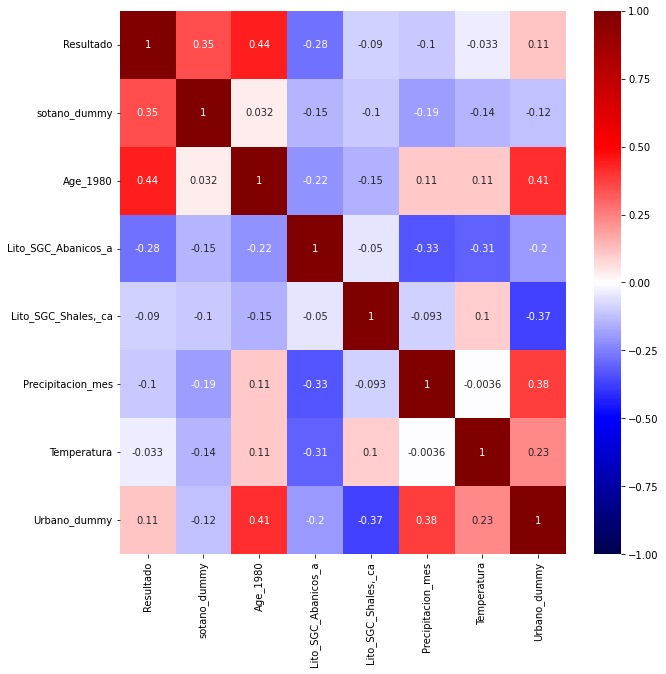

In [28]:
# Selected variables for Statistical analysis
DF_JOIN = DF_JOIN[['Resultado',
                   'sotano_dummy',
                   'Age_1980',
                   'Lito_SGC_Abanicos_a',
                   'Lito_SGC_Shales,_ca',
                   'Precipitacion_mes',
                   'Temperatura',
                   'Urbano_dummy'
                  ]]

Variables = [
             'Basement dummy',
             'House age (1980 dummy)',
             'Lithology Q-ca dummy',
             'Lithology k1k6-Stm dummy',
             'Precipitation [mm]',
             'Temperature [°C]',
             'Urban dummy'
            ]

DF_JOIN.to_csv('Radon concentrations data/Processed_DataFrame.csv')
plt.figure(figsize = (10,10))
sns.heatmap(DF_JOIN.corr(), vmax=1, vmin=-1, center=0, cmap='seismic', annot = True)

## Independent variable caracterization

C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\2062470240.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0,100,200,300,400], family = 'bahnschrift',fontsize=14)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\2062470240.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0,100,200,300,400], family = 'bahnschrift',fontsize=14)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\2062470240.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0,100,200,300,400], family = 'bahnschrift',fontsize=14)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\2062470240.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0,100,200,300,400], family = 'bahnschrift',fontsize=14)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\2062470240.py:35: UserWarning: FixedFormatter should only be u

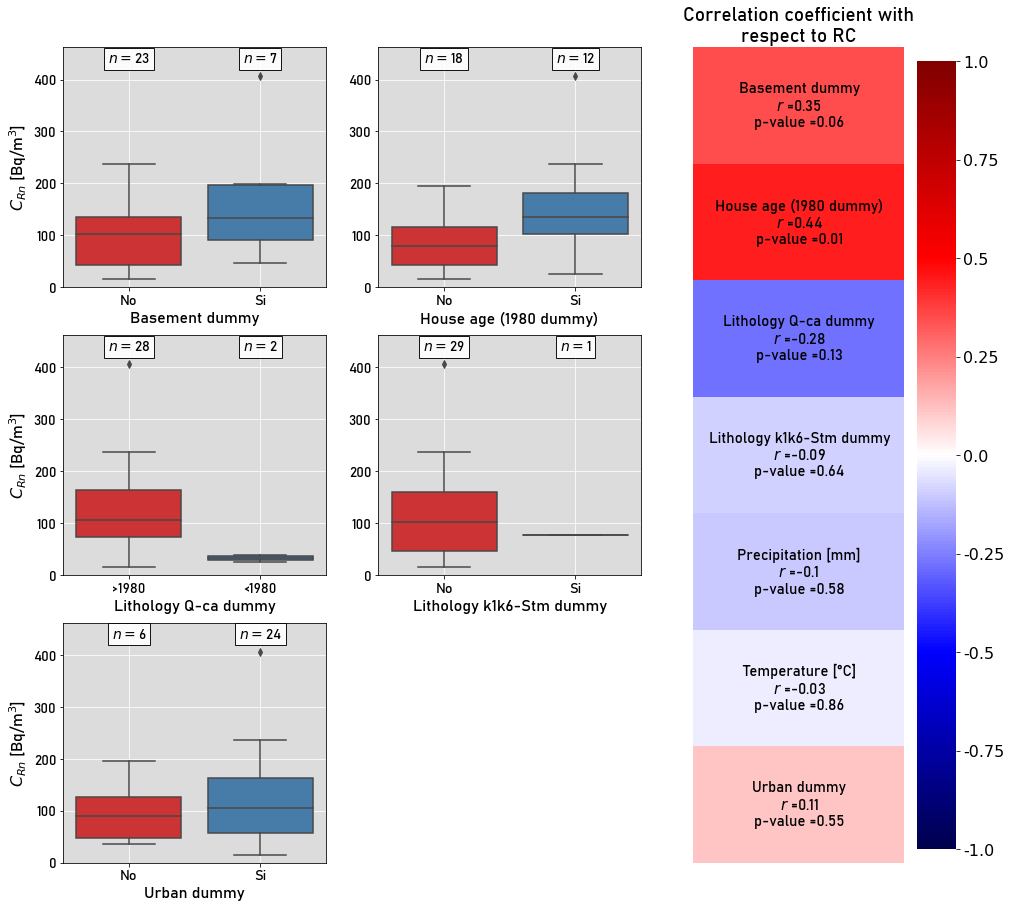

In [7]:
# r-pearson for variables with RC
r_Pvals = []
for i in range(len(DF_JOIN.columns)-1):
    r_Pvals.append(stats.pearsonr(np.array(DF_JOIN.Resultado), np.array(DF_JOIN.iloc[:,i+1])))
    
r_Pvals

fig = plt.figure(figsize = (16,15))
k = 0

for i in [1, 2, 3, 4, 7]:
    
    if k<2:
        plt.subplot2grid((3,3), (0,k))
    elif k < 4:
        plt.subplot2grid((3,3), (1,k-2))
    else:
        plt.subplot2grid((3,3), (2,k-4))
    k+=1
    
    plt.ylim((0,462))
    ax=plt.gca()
    ax.set_facecolor('gainsboro')
    ax.set_axisbelow(True)
    
    ax2 = sns.boxplot(y = DF_JOIN.Resultado, x = DF_JOIN.iloc[:,i], palette = sns.color_palette("Set1"), zorder = 2)
    
    for j in range(len(DF_JOIN.iloc[:,i].unique())):
        if i == 3:
            plt.text(j,440,'$n = $'+str(sum(DF_JOIN.iloc[:,i] == j)), ha = 'center', va = 'center', bbox = dict(facecolor='w', alpha=0.9), fontdict = dict(family = 'bahnschrift', fontsize = 14))
            ax2.set_xticklabels(['>1980', '<1980'], family = 'bahnschrift', fontsize=14)
        else:
            plt.text(j,440,'$n = $'+str(sum(DF_JOIN.iloc[:,i] == j)), ha = 'center', va = 'center', bbox = dict(facecolor='w', alpha=0.9), fontdict = dict(family = 'bahnschrift', fontsize = 14))
            ax2.set_xticklabels(['No', 'Si'], family = 'bahnschrift', fontsize=14)
    ax2.set_yticklabels([0,100,200,300,400], family = 'bahnschrift',fontsize=14)
    if (k != 1) and (k!=3) and (k!=5):
        ax2.set_ylabel('')
    else:
        ax2.set_ylabel('$C_{Rn}$ [Bq/m$^3$]', fontsize=16, family = 'bahnschrift')
    ax2.set_xlabel(Variables[i-1], fontsize=16, family = 'bahnschrift')
    ax2.grid(color = 'w', zorder = -3)
    
ax7 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)

Val = []
for i in range(len(Variables)):
    Val.append(Variables[i] + '\n$r$ =' +str(round(r_Pvals[i][0], 2)) + '\np-value =' +str(round(r_Pvals[i][1], 2)))

ax = sns.heatmap(pd.DataFrame(DF_JOIN.corr()['Resultado'].iloc[1:]), center = 0, vmin = -1, vmax = 1, cmap = 'seismic')
ax.set_yticklabels(Val, rotation = 0, x = 0.52, ha = 'center', family='bahnschrift', fontsize = 15)
ax.figure.axes[-1].set_yticklabels(np.arange(-1, 1.1, 0.25), size=16)
ax.tick_params(length = 0)
ax.set_xticklabels([''], rotation = 0)
ax.set_title('Correlation coefficient with\nrespect to RC', family='bahnschrift', fontsize = 19)

fig.savefig('Figures/Caracterization.png', dpi = 300, bbox_inches = 'tight')

## Principal component Analysis

C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\4209499161.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\4209499161.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)


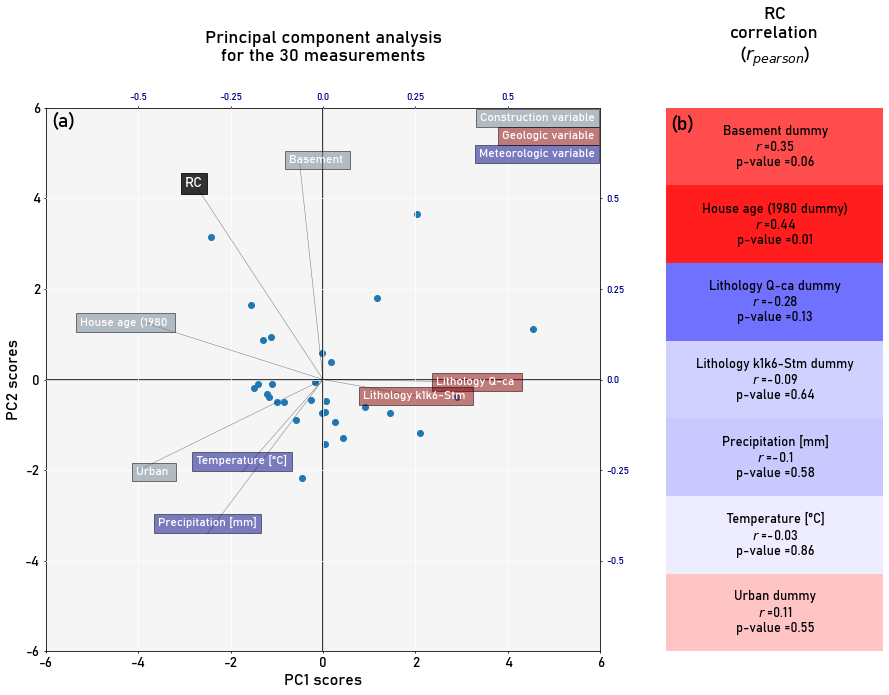

In [8]:
df_PCA = DF_JOIN

# Standarization
df_PCA = df_PCA.apply(lambda df : (df - np.mean(df))/np.std(df) )

Variables.insert(0,'RC')
df_PCA.columns = Variables

df_ = pd.DataFrame(df_PCA.corr().iloc[0,1:])

n_PCA = 5
pca = PCA(n_PCA)
A_postPCA = pca.fit_transform(df_PCA)
A_postPCA = pd.DataFrame(A_postPCA)

# Name the columns
cols = []
for i in range(len(A_postPCA.T)):
    cols.append('PC'+str(i+1))

A_postPCA.columns = cols

EigenVectors = pd.DataFrame(pca.components_.T)

fig = plt.figure(figsize = (15,10))

gs = gspec(10,15)

ax1=fig.add_subplot(gs[:,:10], label="1")
ax2=fig.add_subplot(gs[:,:10], label="2", frame_on=False)

ax1.scatter(A_postPCA.PC1, A_postPCA.PC2)

ax1.set_xlabel("PC1 scores", color="k", fontfamily = 'bahnschrift', fontsize = 16)
ax1.set_ylabel("PC2 scores", color="k", fontfamily  = 'bahnschrift', fontsize = 16)
ax1.tick_params(axis='x', colors="k", length = 2)
ax1.tick_params(axis='y', colors="k", length = 2)
ax2.set_xticks(np.arange(-6,7,2))
ax2.set_yticks(np.arange(-6,7,2))
ax1.set_yticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)
ax1.set_xticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)

plt.grid(True, color = 'w')

ax1.axhline(0,c='k')
ax1.axvline(0,c='k')

ax1.set_xlim(-6,6)
ax1.set_ylim(-6,6)


for i in range(len(EigenVectors)):
    ax2.plot([0,EigenVectors.iloc[i,0]],[0, EigenVectors.iloc[i,1]], c = 'k', lw = 0.5, alpha=0.5)
    if (i == 1)|(i == 7):
        plt.text(EigenVectors.iloc[i,0]+0.05, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='slategrey', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 2):
        plt.text(EigenVectors.iloc[i,0]-0.05, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='slategrey', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 3)|(i == 4)|(i == 9):
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkred', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 1):
        plt.text(EigenVectors.iloc[i,0]-.1, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkred', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 6)|(i == 5):
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1]+0.03, df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkblue', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    else:
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='k', alpha = 0.8), fontsize = 14, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
        

    
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xticks(np.arange(-0.5,.7,.25))
ax2.set_yticks(np.arange(-0.5,.7,.25))
ax2.set_yticklabels(np.arange(-0.5,.7,.25), family = 'bahnschrift', size = 10)
ax2.set_xticklabels(np.arange(-0.5,.7,.25), family = 'bahnschrift', size = 10)
ax2.tick_params(axis='x', colors="darkblue",length = 2)
ax2.tick_params(axis='y', colors="darkblue",length = 2)

ax2.set_xlim(-.75,.75)
ax2.set_ylim(-.75,.75)

plt.text(-0.735,.736,'(a)', ha = 'left', va='top', fontsize = 20, fontfamily = 'bahnschrift')

plt.text(0.735,.736,'Construction variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='slategray', alpha = 0.5), fontfamily = 'bahnschrift')
plt.text(0.735,.686,'Geologic variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='darkred', alpha = 0.5), fontfamily = 'bahnschrift')
plt.text(0.735,.636,'Meteorologic variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='darkblue', alpha = 0.5), fontfamily = 'bahnschrift')


plt.title('Principal component analysis\nfor the 30 measurements', y = 1.075, fontsize = 18, fontfamily = 'bahnschrift')

ax1.set_facecolor('whitesmoke')

ax3 = fig.add_subplot(gs[:,11:], label='3')

df_ = df_PCA.corr(method = 'pearson').apply(lambda df : df[np.abs(df) >= 0.0])
df_ = df_.loc[df_.columns]
df_ = pd.DataFrame(df_.iloc[1:,0])
sns.heatmap(df_, cmap='seismic', vmin = -1,vmax = 1, alpha = 1, cbar = False, zorder = -2)

ax3.tick_params(axis='x', length = 0)
ax3.tick_params(axis='y', length = 0)

Val = []
for i in range(len(df_PCA.columns)-1):
    Val.append(list(df_PCA.columns)[i+1] + '\n$r$ =' +str(round(r_Pvals[i][0], 2)) + '\np-value =' +str(round(r_Pvals[i][1], 2)))
    
ax3.set_yticklabels(Val, rotation = 0, x = 0.52 , ha = 'center', family='bahnschrift', fontsize = 13, color = 'k', zorder = 5)

ax3.set_xticklabels([''], rotation = 0)

plt.text(0.02,0.1,'(b)', ha = 'left', va='top', fontsize = 20, fontfamily = 'bahnschrift')

plt.title('RC\ncorrelation\n($r_{pearson}$)',  y = 1.075, fontsize = 18, fontfamily = 'bahnschrift')

fig.savefig('Figures/PCA_RC.png', dpi  = 170, bbox_inches = 'tight')

Variables.remove('RC')

## Statistical regression models

In [9]:
X = DF_JOIN.iloc[:,1:]
y = DF_JOIN.iloc[:,0]
y_log = y.apply(lambda df: 1 if df >= 100 else 0)
X_log = X
X_log = sm.add_constant(X_log)
X = sm.add_constant(X)

### Linear regression

In [10]:
lin_reg = sm.OLS(np.log(y), X).fit(maxiter=1000000)

RMSE = np.sqrt(np.sum((lin_reg.predict(X)-np.log(y))**2)/30)

print('RMSE:', RMSE)

lin_reg.summary()

RMSE: 0.5855048660588713


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Resultado   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     1.866
Date:                Tue, 21 Jun 2022   Prob (F-statistic):              0.124
Time:                        09:27:35   Log-Likelihood:                -26.510
No. Observations:                  30   AIC:                             69.02
Df Residuals:                      22   BIC:                             80.23
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.3958      8.839      1.402      0.175      -5.935      30.727
sotano_dummy            0.2748      0.322      0.853      0.403      -0.394       0.943
Age_1980                0.5726      0.284      2.013      0.056      -0.017       1.162
Lito_SGC_Abanicos_a    -1.1717      0.598     -1.958      0.063      -2.413       0.069
Lito_SGC_Shales,_ca    -0.0051      0.778     -0.007      0.995      -1.619       1.609
Precipitacion_mes      -0.0109      0.011     -1.018      0.320      -0.033       0.011
Temperatura            -0.4844      0.599     -0.809      0.427      -1.727       0.758
Urbano_dummy           -0.0541      0.409     -0.132      0.896      -0.903       0.795
==============================================================================
Omnibus:                        8.438   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                6.746
Skew:                          -1.010   Prob(JB):                       0.0343
Kurtosis:                       4.147   Cond. No.                     7.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\3761387264.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Val, family = 'bahnschrift', fontsize = 14)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\3761387264.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(-100,150,50), family = 'bahnschrift', fontsize = 14)


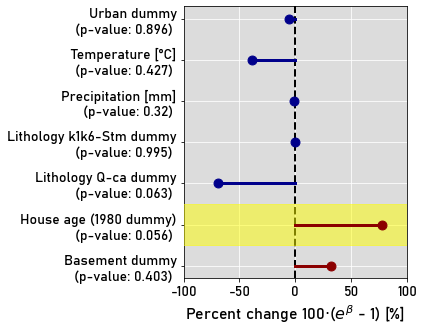

In [11]:
fig = plt.figure(figsize = (4,5))

plt.grid(True, which = 'both',  zorder = -3, c = 'w')

for i in range(len(lin_reg.params.iloc[:-1])):
    if lin_reg.params.iloc[i+1] > 0:
        plt.scatter(np.exp(lin_reg.params.iloc[i+1]) - 1, Variables[i], s = 80, c = 'darkred', zorder = 4)
        plt.plot([0,np.exp(lin_reg.params.iloc[i+1]) - 1], [Variables[i], Variables[i]], c = 'darkred', linewidth = 3, zorder = 4)
    else:
        plt.scatter(np.exp(lin_reg.params.iloc[i+1]) - 1, Variables[i], s = 80, c = 'darkblue', zorder = 4)
        plt.plot([0,(np.exp(lin_reg.params.iloc[i+1]) - 1)], [Variables[i], Variables[i]], c = 'darkblue', linewidth = 3, zorder = 4)

Val = []
for i in range(len(Variables)):
    Val.append(Variables[i] + '\n(p-value: '+str(round(lin_reg.pvalues.iloc[i+1],3))+') ')
        
ax = plt.gca()

ax.set_xlabel('Percent change 100$\cdot$($e^{\u03B2}$ - 1) [%]', family = 'bahnschrift', fontsize = 16)
ax.set_yticklabels(Val, family = 'bahnschrift', fontsize = 14)
ax.set_xticklabels(np.arange(-100,150,50), family = 'bahnschrift', fontsize = 14)
ax.set_facecolor('gainsboro')

plt.axvline(0, c = 'k',ls='--', lw=2)

# plt.fill_between([-2,2],2.5,1.5, zorder = 3, color = 'yellow', alpha = 0.5)
plt.fill_between([-2,2],0.5,1.5, zorder = 3, color = 'yellow', alpha = 0.5)

plt.xlim((-1,1))

fig.savefig('Figures/Regresión_LogLineal.png', dpi = 200, bbox_inches = 'tight')

## Check linear regression assumptions

Relationship is homoscedastic
No autocorrelation problem


,VIF Factor,features
0,1.19,sotano_dummy
1,1.25,Age_1980
2,1.43,Lito_SGC_Abanicos_a
3,1.25,"Lito_SGC_Shales,_ca"
4,1.43,Precipitacion_mes
5,1.28,Temperatura
6,1.72,Urbano_dummy


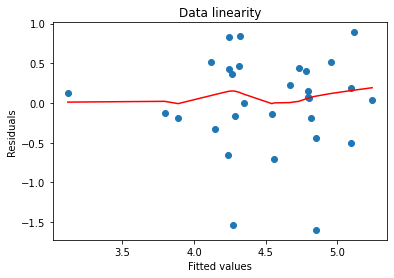

In [12]:
p_val = 0.05

# Heteroscedasticidad
if smd.het_breuschpagan(lin_reg.resid, lin_reg.model.exog)[1] < p_val:
    print('Relationship is not homoscedastic')
else:
    print('Relationship is homoscedastic')
    
# Autocorrelación
if (durbin_watson(lin_reg.resid) < 2.5) & (durbin_watson(lin_reg.resid) > (1.5)):
    print('No autocorrelation problem')
else:
    print('There maybe autocorrelation problems')
    
# Linearidad
plt.scatter(lin_reg.predict(X), lin_reg.resid)
plt.ylabel('Residuals')
plt.xlabel('Fitted values')
plt.plot(lowess(lin_reg.resid, lin_reg.predict(X))[:,0], lowess(lin_reg.resid, lin_reg.predict(X))[:,1], c='r') 
plt.title('Data linearity')
    
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i+1) for i in range(X.shape[1]-1)]
vif["features"] = X.columns[1:]
vif.round(2)

## Apply models to Household data

In [13]:
# Unzip IndVarModel file
with zipfile.ZipFile("Independent variables/Houses_IndVar_model.zip", 'r') as zip_ref:
    zip_ref.extractall("Independent variables")

In [14]:
df_RnModel = pd.read_table("Independent variables/Houses_IndVar_model.txt", delimiter = ',')

df_RnModel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725932 entries, 0 to 725931
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   OID_            725932 non-null  int64  
 1   Join_Count      725932 non-null  int64  
 2   TARGET_FID      725932 non-null  int64  
 3   Join_Count_1    725932 non-null  int64  
 4   TARGET_FID_1    725932 non-null  int64  
 5   COD_1           725932 non-null  object 
 6   MEAN_CONNPISOS  725932 non-null  float64
 7   MAX_CONNSOTANO  725932 non-null  int64  
 8   MEAN_BASEMENT   725932 non-null  float64
 9   MEAN_AGE_RANK   725932 non-null  float64
 10  ORIG_FID        725932 non-null  int64  
 11  SimboloUC       725932 non-null  object 
 12  Descripcion     725932 non-null  object 
 13  SueCodigo       725802 non-null  float64
 14  SueCSuelo       725802 non-null  float64
 15  SueAAdmini      725802 non-null  object 
 16  SueArea         725802 non-null  float64
 17  Shape_Leng

In [15]:
df_age = pd.read_csv('Independent variables/construction_vars_houses_Bogotá.csv')
df_RnModel = df_RnModel.join(df_age, lsuffix='COD_1',rsuffix='COD')
df_RnModel

,OID_,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,COD_1,MEAN_CONNPISOS,MAX_CONNSOTANO,MEAN_BASEMENT,MEAN_AGE_RANK,...,MEAN_1,COD_12_13_14,ZONE_CODE_12,COUNT_12,AREA_12,MEAN_12,Unnamed: 0,COD,BASEMENT,Age_rank
0,1,1,1,1,1,A001101002001,1.0,0,0.0,5.0,...,13.685174,A001101002001,1,1.0,6400.0,166.346375,0,A001101002001,0,1
1,2,1,2,1,2,A001101002002,2.0,0,0.0,9.0,...,13.685174,A001101002002,2,1.0,6400.0,166.346375,1,A001101002002,0,1
2,3,1,3,1,3,A001101002003,1.5,0,0.0,5.0,...,13.685174,A001101002003,3,1.0,6400.0,166.346375,2,A001101002003,0,1
3,4,1,4,1,4,A001101002004,1.0,0,0.0,3.0,...,13.685174,A001101002004,4,1.0,6400.0,166.346375,3,A001101002004,0,0
4,5,1,5,1,5,A001101002005,1.0,0,0.0,5.0,...,13.681986,A001101002005,5,1.0,6400.0,166.702896,4,A001101002005,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725927,725928,1,725928,1,725928,A209106005023,2.0,0,0.0,3.0,...,14.474215,A209106005023,725928,1.0,6400.0,103.102890,725927,A209106005009,0,0
725928,725929,1,725929,1,725929,A209106005024,1.0,0,0.0,4.0,...,14.474206,A209106005024,725929,1.0,6400.0,103.102196,725928,A209106005011,0,0
725929,725930,1,725930,1,725930,A209106005025,1.5,0,0.0,4.0,...,14.474215,A209106005025,725930,1.0,6400.0,103.102890,725929,A209106005013,0,0
725930,725931,1,725931,1,725931,A209106006001,1.0,0,0.0,4.0,...,14.474200,A209106006001,725931,1.0,6400.0,103.104027,725930,A209106005014,0,0


In [16]:
df_RnModel = df_RnModel.dropna()

df_RnModel['Urban_dummy'] = df_RnModel['SueCodigo'].apply(lambda df : 1 if df == 1 else 0)

# Create dummy variables
for i in df_RnModel['SimboloUC'].unique():
    df_RnModel['Lito_SGC_'+i.replace('-','_')[:10]] = df_RnModel.apply(lambda df : 1 if df['SimboloUC'] == i else 0, axis = 1)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\1978115329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RnModel['Urban_dummy'] = df_RnModel['SueCodigo'].apply(lambda df : 1 if df == 1 else 0)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\1978115329.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RnModel['Lito_SGC_'+i.replace('-','_')[:10]] = df_RnModel.apply(lambda df : 1 if df['SimboloUC'] == i else 0, axis = 1)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\1978115329.py:7: Setti

In [17]:
df_RnModel['Constant'] = np.ones(len(df_RnModel))

df_RnModel = df_RnModel[(df_RnModel['SimboloUC'] == 'Q1-l')|
                        (df_RnModel['SimboloUC'] == 'Q-ca')|
                        (df_RnModel['SimboloUC'] == 'k1k6-Stm')]

df_RnModel = df_RnModel[['COD_1',
                         'Constant',
                         'MEAN_BASEMENT',
                         'Age_rank',
                         'Lito_SGC_Q_ca',
                         'Lito_SGC_k1k6_Stm',
                         'MEAN_12', 
                         'MEAN_1', 
                         'Urban_dummy']]

C:\Users\mdomi\AppData\Local\Temp\ipykernel_14964\1604927929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RnModel['Constant'] = np.ones(len(df_RnModel))


In [18]:
df_RnModel.columns = ['COD',
                      'Constant',
                      'Basement_dummy',
                      'Age_1980_dummy',
                      'Lito_Fans',
                      'Lito_Shales',
                      'Precipitation', 
                      'Temperature', 
                      'Urban_dummy',
                     ]

# df_RnModel['Fault_proximity'] = df_RnModel['Fault_proximity']*111000

In [19]:
df_RnModel

,COD,Constant,Basement_dummy,Age_1980_dummy,Lito_Fans,Lito_Shales,Precipitation,Temperature,Urban_dummy
7,A001101002009,1.0,0.0,1,0,0,164.550659,13.711655,1
8,A001101002010,1.0,0.0,1,0,0,164.550659,13.711655,1
9,A001101002012,1.0,0.0,1,0,0,164.550659,13.711655,1
10,A001101002013,1.0,0.0,1,0,0,164.550659,13.711655,1
11,A001101002014,1.0,0.0,1,0,0,164.550659,13.711655,1
...,...,...,...,...,...,...,...,...,...
725871,A208203097002,1.0,0.0,0,0,1,94.140129,14.351622,0
725872,A208203097003,1.0,0.0,0,0,1,94.140129,14.351622,0
725873,A208203097004,1.0,0.0,0,0,1,94.140129,14.351622,0
725874,A208203097005,1.0,0.0,0,0,1,94.140129,14.351622,0


### Linear regession

In [20]:
df_RnModel['LinReg'] = np.exp(lin_reg.predict(df_RnModel.iloc[:,1:]))
df_RnModel['LinReg'] = np.where(df_RnModel.LinReg<0, 0, df_RnModel.LinReg)

In [23]:
df_RnModel[['COD','LinReg']].to_csv('Regression results/LinReg_model_results.csv')

In [22]:
df_RnModel.describe()

,Constant,Basement_dummy,Age_1980_dummy,Lito_Fans,Lito_Shales,Precipitation,Temperature,Urban_dummy,LinReg
count,551570.0,551570.000000,551570.000000,551570.000000,551570.000000,551570.000000,551570.000000,551570.000000,551570.000000
mean,1.0,0.005216,0.367651,0.246710,0.046872,105.871555,14.477634,0.989252,69.494334
std,0.0,0.072033,0.482166,0.431097,0.211364,17.964786,0.294393,0.103112,33.557349
min,1.0,0.000000,0.000000,0.000000,0.000000,60.296017,13.400901,0.000000,15.610264
25%,1.0,0.000000,0.000000,0.000000,0.000000,92.480141,14.323193,1.000000,46.035227
50%,1.0,0.000000,0.000000,0.000000,0.000000,104.341110,14.453475,1.000000,64.828722
75%,1.0,0.000000,1.000000,0.000000,0.000000,114.446915,14.688022,1.000000,103.280546
max,1.0,1.000000,1.000000,1.000000,1.000000,185.944550,15.744415,1.000000,248.344637


(array([407243., 144327.]),
 array([  0, 100, 250]),
 <BarContainer object of 2 artists>)

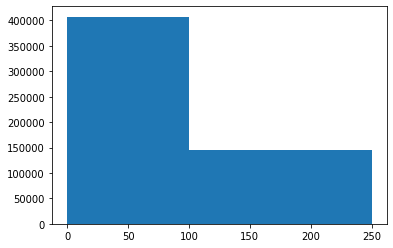

In [46]:
plt.hist(df_RnModel.LinReg, bins = [0,100,250])

In [48]:
144327*2.9

418548.3